# Practice 1: Convolutional Neural Network - Deep Learning course

*   Alejandro Dopico Castro (alejandro.dopico2@udc.es).
*   Ana Xiangning Pereira Ezquerro (ana.ezquerro@udc.es).

In [1]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from logging import ERROR
tf.get_logger().setLevel(ERROR)
import warnings, os
import plotly.express as px
warnings.filterwarnings("ignore")
from utils import *
from models import *
from typing import List, Tuple
model_accuracies: List[Tuple[str, int]] = []

# global variables 
IMG_SIZE = 100
BATCH_SIZE = 258
base_dir = 'animals/'
model_dir = 'results/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    

2024-03-06 13:14:24.550912: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 13:14:24.586340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 13:14:24.586366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 13:14:24.587207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 13:14:24.592321: I tensorflow/core/platform/cpu_feature_guar

## Table of Contents 

1. [Dataset preprocessing](#exercise-1-dataset-preprocessing)
2. [Custom Convolutional Models](#exercise-2-custom-convolutional-models)
    - [Simple Model](#21-simple-model)
    - [Mid Complex Model](#22-mid-complex-model)
    - [Model with residual connections](#23-model-with-residual-connections)
    - [Inception block](#24-inception-block)
    - [What happens if we add Data Augmentation?](#25-what-if-we-add-data-augmentation)
    - [Custom models comparison](#26-custom-models-comparison)
3. [Pretrained Models](#exercise-3-pretrained-models)
    - [Fine-tuning](#31-fine-tuning)
    - [Feature Extraction](#32-feature-extraction)
    - [Partial Fine-tuning](#33-partial-fine-tuning)
    - [Comparison between pretrained approaches](#34-comparison-between-pretrained-approaches)
4. [Comparison](#4-results-and-comparison)

## Exercise 1. Dataset preprocessing

We decided to use for the image resolution $80\times 80$ for retrieving similar results than considering higher resolutions with the simpler architectures. The batch size is adapted to fit the GPU capabilities of the local machine. We used the original validation set for evaluation a split a 15% of the data for validation. All the input images were normalized to fit the range $[0,1]$ with the [Rescaling layer](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/).

In [2]:
train_dataset, val_dataset, test_dataset = load_data(base_dir, IMG_SIZE, BATCH_SIZE)

Found 13474 files belonging to 5 classes.
Using 11453 files for training.
Using 2021 files for validation.


2024-03-06 13:14:26.720720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-03-06 13:14:26.721182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20987 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Found 1497 files belonging to 5 classes.


## Exercise 2. Custom Convolutional Models

For this exercise, we prepared four different convolutional architectures with increasing complexity and regularization methods to tackle the animal classification problem: ([1](#21-simple-model)) a simple linear approach with 2 convolutional layers interleaved with max-pooling, ([2](#22-mid-complex-model)) a more complex convolutional-linear model with 3 blocks of paired convolutions and max-poolings, ([3](#23-model-with-residual-connections)) a convolutional architecture based on residual connections ([He et al., 2015](https://arxiv.org/abs/1512.03385)), ([4](#24-inception-block)) the integration of the Inception block ([Szegedy et al., 2014](https://arxiv.org/abs/1409.4842)). We used the validation split to tune each hyperparameter configuration (although not all experiments are included in this notebook to facilitate the readibility) and applied some regularization methods learnt in previous practical lessons to avoid overfitting.

### 2.1. Simple Model

In [3]:
simple_model = SimpleModel(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
simple_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
simple_model_history = train_model(simple_model, train_dataset, val_dataset, epochs=20, path=model_dir, batch_size=BATCH_SIZE, verbose=1).history
print(
    f"Final loss: training -> {simple_model_history['loss'][-1]:.2f}, validation -> {simple_model_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {simple_model_history['acc'][-1]:.2f}, \
        validation -> {simple_model_history['val_acc'][-1]:.2f}"
)
plot_history(simple_model_history, ['loss', 'acc'], name='Simple Model')

Epoch 1/20


2024-03-06 13:14:29.462859: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 13:14:30.009681: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f25ae1ab6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 13:14:30.009703: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-06 13:14:30.009707: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-06 13:14:30.014211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709727270.109956  121659 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 9s 127ms/step - loss: 3.6627 - acc: 0.3610 - val_loss: 1.1262 - val_acc: 0.5715 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - 5s 96ms/step - loss: 0.9838 - acc: 0.6475 - val_loss: 0.9295 - val_acc: 0.6591 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - 5s 96ms/step - loss: 0.8613 - acc: 0.6934 - val_loss: 0.8408 - val_acc: 0.6912 - lr: 0.0010
Epoch 4/20
45/45 [==============================] - 5s 95ms/step - loss: 0.7656 - acc: 0.7303 - val_loss: 0.7971 - val_acc: 0.7001 - lr: 0.0010
Epoch 5/20
45/45 [==============================] - 5s 95ms/step - loss: 0.7092 - acc: 0.7461 - val_loss: 0.7881 - val_acc: 0.7061 - lr: 0.0010
Epoch 6/20
45/45 [==============================] - 5s 95ms/step - loss: 0.6623 - acc: 0.7645 - val_loss: 0.7625 - val_acc: 0.7115 - lr: 0.0010
Epoch 7/20
45/45 [==============================] - 5s 94ms/step - loss: 0.6283 - acc: 0.7798 - val_loss: 0.7753 - val_acc: 0.7081 - lr: 0.0010
Ep

In [4]:
test_loss, test_accuracy = simple_model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
print(simple_model.summary())
model_accuracies.append(("SimpleModel", test_accuracy))

6/6 [==============================] - 1s 71ms/step - loss: 0.6536 - acc: 0.7615
Model evaluated: Test Loss-> 0.6535845398902893, Test Accuracy -> 76.15%
Model: "SimpleModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0 (unused)
 g2D)                            

### 2.2 Mid Complex Model

In [5]:
mid_model = MidModel(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
mid_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mid_model_history = train_model(
    mid_model, 
    train_dataset, 
    val_dataset, 
    epochs=30, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    path=model_dir, 
    lr_patience=5, 
    val_patience=10
).history
print(
    f"Final loss: training -> {mid_model_history['loss'][-1]:.2f}, validation -> {mid_model_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mid_model_history['acc'][-1]:.2f}, validation -> {mid_model_history['val_acc'][-1]:.2f}"
)
plot_history(mid_model_history, ['loss', 'acc'], name='Mid Complex Model')

Epoch 1/30


2024-03-06 13:16:13.964585: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inMidModel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 [==============================] - 15s 158ms/step - loss: 1.4449 - acc: 0.3767 - val_loss: 1.1846 - val_acc: 0.5507 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - 6s 101ms/step - loss: 0.9544 - acc: 0.6245 - val_loss: 0.7623 - val_acc: 0.6873 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - 6s 101ms/step - loss: 0.6993 - acc: 0.7193 - val_loss: 0.6569 - val_acc: 0.7358 - lr: 0.0010
Epoch 4/30
45/45 [==============================] - 6s 101ms/step - loss: 0.6315 - acc: 0.7491 - val_loss: 0.6193 - val_acc: 0.7476 - lr: 0.0010
Epoch 5/30
45/45 [==============================] - 6s 101ms/step - loss: 0.5467 - acc: 0.7836 - val_loss: 0.5521 - val_acc: 0.7848 - lr: 0.0010
Epoch 6/30
45/45 [==============================] - 6s 101ms/step - loss: 0.4882 - acc: 0.8070 - val_loss: 0.5235 - val_acc: 0.7947 - lr: 0.0010
Epoch 7/30
45/45 [==============================] - 6s 101ms/step - loss: 0.4644 - acc: 0.8166 - val_loss: 0.5080 - val_acc: 0.8016 - lr: 0.

In [39]:
test_loss, test_accuracy = mid_model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(('MidModel', test_accuracy))
mid_model.summary()

6/6 [==============================] - 0s 18ms/step - loss: 0.5839 - acc: 0.8597
Model evaluated: Test Loss-> 0.583864152431488, Test Accuracy -> 85.97%
Model: "MidModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  896       
                                                                 
 conv2d_3 (Conv2D)           multiple                  9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           multiple                  0         
                                     

### 2.3 Model with residual connections

In [7]:
resnet = CustomResNet(num_classes=5)
optimizer = Adam(learning_rate=1e-3)
resnet.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet_history = train_model(
    resnet,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10,
).history
print(
    f"Final loss: training -> {resnet_history['loss'][-1]:.2f}, validation -> {resnet_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_history['acc'][-1]:.2f}, validation -> {resnet_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_history, ['loss', 'acc'], name='Custom ResNet')

Epoch 1/50


45/45 [==============================] - 19s 194ms/step - loss: 1.5172 - acc: 0.4631 - val_loss: 10.9277 - val_acc: 0.2093 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 6s 111ms/step - loss: 0.7299 - acc: 0.7146 - val_loss: 9.4116 - val_acc: 0.2088 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 6s 111ms/step - loss: 0.5473 - acc: 0.7847 - val_loss: 4.3774 - val_acc: 0.2088 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 6s 111ms/step - loss: 0.4486 - acc: 0.8232 - val_loss: 3.9654 - val_acc: 0.2241 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 6s 98ms/step - loss: 0.3855 - acc: 0.8484 - val_loss: 4.1203 - val_acc: 0.2306 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 6s 99ms/step - loss: 0.3269 - acc: 0.8714 - val_loss: 4.2247 - val_acc: 0.2662 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - 6s 111ms/step - loss: 0.2884 - acc: 0.8882 - val_loss: 2.2821 - val_acc: 0.3686 - lr: 0.0

In [8]:
test_loss, test_accuracy = resnet.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("ResNet", test_accuracy))
resnet.summary()

6/6 [==============================] - 1s 159ms/step - loss: 0.5247 - acc: 0.8998
Model evaluated: Test Loss-> 0.5246843099594116, Test Accuracy -> 89.98%
Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     multiple                  0         
                                                                 
 zero_padding2d (ZeroPaddin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple

### 2.4. Inception block

In [9]:
inception = InceptionModel(num_classes=5, num_blocks=3, n_filters=[(32, 32, 64, 64) for _ in range(3)], kernel_size=7, dropout=0)
optimizer = Adam(learning_rate=1e-4)
inception.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
inception_history = train_model(
    inception,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {inception_history['loss'][-1]:.2f}, validation -> {inception_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {inception_history['acc'][-1]:.2f}, validation -> {inception_history['val_acc'][-1]:.2f}"
)
plot_history(inception_history, ['loss', 'acc'], name='Inception Model')

Epoch 1/50


45/45 [==============================] - 125s 1s/step - loss: 1.0615 - acc: 0.6404 - val_loss: 1.4642 - val_acc: 0.3632 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 20s 409ms/step - loss: 0.5368 - acc: 0.8014 - val_loss: 1.5318 - val_acc: 0.4008 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 20s 410ms/step - loss: 0.3567 - acc: 0.8662 - val_loss: 2.4272 - val_acc: 0.2301 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 20s 409ms/step - loss: 0.2218 - acc: 0.9189 - val_loss: 1.7689 - val_acc: 0.3553 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 20s 410ms/step - loss: 0.1432 - acc: 0.9549 - val_loss: 2.3439 - val_acc: 0.3182 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 20s 410ms/step - loss: 0.0900 - acc: 0.9733 - val_loss: 2.2913 - val_acc: 0.3419 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 20s 425ms/step - loss: 0.0324 - acc: 0.9955 - val_loss: 1.427

In [10]:
test_loss, test_accuracy = inception.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss -> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("Inception", test_accuracy))
inception.summary()

6/6 [==============================] - 8s 1s/step - loss: 0.4982 - acc: 0.8484
Model evaluated: Test Loss -> 0.49821019172668457, Test Accuracy -> 84.84%
Model: "InceptionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     multiple                  0         
                                                                 
 inception (Inception)       multiple                  83872     
                                                                 
 inception_1 (Inception)     multiple                  95584     
                                                                 
 inception_2 (Inception)     multiple                  95584     
                                                                 
 conv2d_35 (Conv2D)          multiple                  602176    
                                                                 
 conv2d_43 (Conv2D)          m

### 2.5 What if we add Data Augmentation?

In [11]:
from keras.models import Sequential
resnet_data_aug = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.GaussianNoise(0.01),
    CustomResNet(num_classes=5)
], name='ResNetAug')

resnet_data_aug.compile(optimizer="adam", loss="sparse_categorical_crossentropy",  metrics=[SparseCategoricalAccuracy('acc')])
resnet_data_aug_history = train_model(
    resnet_data_aug,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10,
).history

print(
    f"Final loss: training -> {resnet_data_aug_history['loss'][-1]:.2f}, validation -> {resnet_data_aug_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_data_aug_history['acc'][-1]:.2f}, validation -> {resnet_data_aug_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_data_aug_history, ['loss', 'acc'], name='Augmented ResNet Model')

Epoch 1/50


45/45 [==============================] - 12s 118ms/step - loss: 1.6661 - acc: 0.3723 - val_loss: 7.5502 - val_acc: 0.2078 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 6s 112ms/step - loss: 1.1806 - acc: 0.5069 - val_loss: 5.3597 - val_acc: 0.2118 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 6s 99ms/step - loss: 0.8754 - acc: 0.6548 - val_loss: 7.3926 - val_acc: 0.2093 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 6s 100ms/step - loss: 0.6865 - acc: 0.7347 - val_loss: 7.9376 - val_acc: 0.2123 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 6s 100ms/step - loss: 0.6097 - acc: 0.7596 - val_loss: 7.2052 - val_acc: 0.2232 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 6s 100ms/step - loss: 0.5606 - acc: 0.7790 - val_loss: 5.9844 - val_acc: 0.2726 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - 6s 112ms/step - loss: 0.5066 - acc: 0.8040 - val_loss: 3.0186 - val_acc: 0.3404 - lr: 0.0

In [12]:
test_loss, test_accuracy = resnet_data_aug.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
model_accuracies.append(("AugmentedResNet", test_accuracy))
resnet_data_aug.summary()

6/6 [==============================] - 0s 17ms/step - loss: 0.2235 - acc: 0.9259
Model evaluated: Test Loss-> 0.22353005409240723, Test Accuracy -> 92.59%
Model: "ResNetAug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 100, 100, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 100, 100, 3)       0         
                                                                 
 gaussian_noise (GaussianNo  (None, 100, 100, 3)       0         
 ise)                                                            
                                                                 
 ResNet (CustomResNet)       (None

### 2.6. Custom models comparison

In the next output we have displayed the accuracy performance of each custom model in the train and test set to analyze the overfitting behavior. 

In [47]:
models = [simple_model, mid_model, inception, resnet, resnet_data_aug]
comparison(models, (train_dataset, test_dataset))

The left figure shows each model performance in the train (blue) and test (orange) sets. We see that for all models the performance is considerably better in the train set (99%) than in the evaluation samples (75-85%), proving the network is learning the train set characteristics instead of generalizing image information for the given task. The right figure shows the disadvantage of using larger networks with more complex connections (Inception), inducing a higher difference between the train and test set. Additionally, we see the impact of regularizing the network via data augmentation (ResNetAug). The result is the smaller difference between the train and test set.

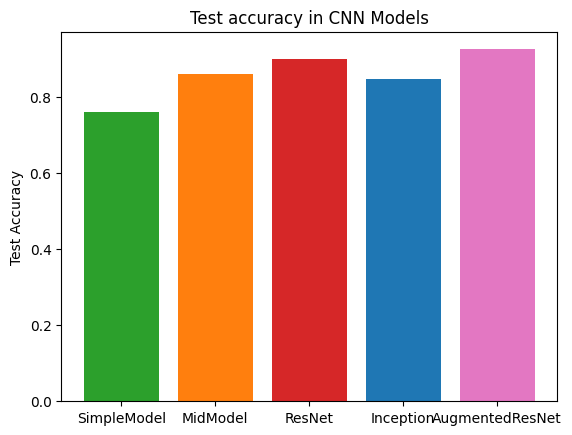

In [43]:
fig, ax = plt.subplots()
models = [name for name, _ in model_accuracies]
accuracies = [accuracy for _, accuracy in model_accuracies]
bar_colors = ["tab:green", "tab:orange", "tab:red", "tab:blue", 'tab:pink']
ax.bar(models, accuracies, label=models, color=bar_colors)

ax.set_ylabel("Test Accuracy")
ax.set_title("Test accuracy in CNN Models")
plt.show()

## Exercise 3. Pretrained models

For this exercise we conducted experiments with three pretrained models available in the [Keras Applications website](https://keras.io/api/applications/) pretrained with ImageNet dataset: [ResNet-50](https://keras.io/api/applications/resnet/#resnet50v2-function) ([He et al., 2016](https://aruexiv.org/abs/1603.05027)), [MobileNet-V2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) ([Sandler et al.,, 2018](https://arxiv.org/abs/1801.04381)) and [EfficientNet-B0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function) ([Tan & Le, 2019](https://arxiv.org/abs/1905.11946)). Our first approach uses transfer learning, using the pretrained models to use that previous knowledge. The second round is fine-tuning, where we train the model with the feature-extractor freezed, to train the top (classifier) and then do a little round of epochs with very low learning rate with the pretrained model unfreezed to adapt its weights to our dataset. The last approaches explores defreezing only the last 10 layers of each architecture to test if maintaining a large ratio of trainable weights does not impact in the overal performance.

### 3.1. Transfer-learning



#### ResNet-50 V2

In [15]:
resnet_t = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='resnet', name='ResNet-t', defreeze=0)
optimizer = Adam(learning_rate=1e-4)
resnet_t.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet_t_history = train_model(
    resnet_t,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {resnet_t_history['loss'][-1]:.2f}, validation -> {resnet_t_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_t_history['acc'][-1]:.2f}, validation -> {resnet_t_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_t_history, ['loss', 'acc'], name=f'{resnet_t.name} Model')
test_loss, test_accuracy = resnet_t.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
resnet_t.summary()

Epoch 1/50
45/45 [==============================] - 12s 174ms/step - loss: 0.6880 - acc: 0.8668 - val_loss: 0.3530 - val_acc: 0.8976 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 7s 136ms/step - loss: 0.0794 - acc: 0.9756 - val_loss: 0.2911 - val_acc: 0.9154 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0193 - acc: 0.9968 - val_loss: 0.3115 - val_acc: 0.9154 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 6s 100ms/step - loss: 0.0070 - acc: 0.9996 - val_loss: 0.3174 - val_acc: 0.9129 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 6s 100ms/step - loss: 0.0041 - acc: 0.9997 - val_loss: 0.3262 - val_acc: 0.9124 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0033 - acc: 0.9997 - val_loss: 0.3284 - val_acc: 0.9144 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0

#### MobileNet V2

In [16]:
mobile_t = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='mobile', name='Mobile-t', defreeze=0)
optimizer = Adam(learning_rate=1e-4)
mobile_t.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mobile_t_history = train_model(
    mobile_t,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {mobile_t_history['loss'][-1]:.2f}, validation -> {mobile_t_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mobile_t_history['acc'][-1]:.2f}, validation -> {mobile_t_history['val_acc'][-1]:.2f}"
)
plot_history(mobile_t_history, ['loss', 'acc'], name=f'{mobile_t.name} Model')
test_loss, test_accuracy = mobile_t.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mobile_t.summary()

Epoch 1/50
45/45 [==============================] - 9s 133ms/step - loss: 0.5519 - acc: 0.8721 - val_loss: 0.2807 - val_acc: 0.9228 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 6s 117ms/step - loss: 0.1292 - acc: 0.9566 - val_loss: 0.1832 - val_acc: 0.9406 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 5s 95ms/step - loss: 0.0451 - acc: 0.9865 - val_loss: 0.2053 - val_acc: 0.9342 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 6s 117ms/step - loss: 0.0182 - acc: 0.9966 - val_loss: 0.1818 - val_acc: 0.9456 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 5s 95ms/step - loss: 0.0087 - acc: 0.9992 - val_loss: 0.1887 - val_acc: 0.9411 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 5s 95ms/step - loss: 0.0049 - acc: 0.9997 - val_loss: 0.1920 - val_acc: 0.9431 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 5s 95ms/step - loss: 0.0037 - acc: 0.9997 - val_loss: 0.1

#### Xception

In [17]:
xception_t = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='xception', name='Xception-t', defreeze=0)
optimizer = Adam(learning_rate=1e-4)
xception_t.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
xception_t_history = train_model(
    xception_t,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {xception_t_history['loss'][-1]:.2f}, validation -> {xception_t_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {xception_t_history['acc'][-1]:.2f}, validation -> {xception_t_history['val_acc'][-1]:.2f}"
)
plot_history(xception_t_history, ['loss', 'acc'], name=f'{xception_t.name} Model')
test_loss, test_accuracy = xception_t.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
xception_t.summary()

Epoch 1/50
45/45 [==============================] - 10s 149ms/step - loss: 0.3645 - acc: 0.8734 - val_loss: 0.2682 - val_acc: 0.9040 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 7s 125ms/step - loss: 0.1732 - acc: 0.9371 - val_loss: 0.2500 - val_acc: 0.9119 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 7s 124ms/step - loss: 0.1255 - acc: 0.9543 - val_loss: 0.2329 - val_acc: 0.9179 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 7s 124ms/step - loss: 0.0928 - acc: 0.9707 - val_loss: 0.2257 - val_acc: 0.9233 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0691 - acc: 0.9815 - val_loss: 0.2313 - val_acc: 0.9213 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 6s 99ms/step - loss: 0.0556 - acc: 0.9864 - val_loss: 0.2319 - val_acc: 0.9233 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 6s 100ms/step - loss: 0.0402 - acc: 0.9921 - val_loss: 

### 3.2. Fine-tuning


#### ResNet-50 V2

In [18]:
resnet_f = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='resnet', defreeze = 0, name='ResNet-f')
optimizer = Adam(learning_rate=1e-3)
resnet_f.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])

print("Training only the classifier")
train_model(
    resnet_f,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=1,
    verbose=1,
    lr_patience=3,
    val_patience=5,
)

print("Finetuning the model with a learning rate of 1e-5")
resnet_f.trainable = True
optimizer = Adam(learning_rate=1e-5)
resnet_f.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])

resnet_f_history = train_model(
    resnet_f,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=1,
    verbose=1,
    lr_patience=2,
    val_patience=2,
).history

print(
    f"Final loss: training -> {resnet_f_history['loss'][-1]:.2f}, validation -> {resnet_f_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_f_history['acc'][-1]:.2f}, validation -> {resnet_f_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_f_history, ['loss', 'acc'], name=f'{resnet_f.name} Model')
test_loss, test_accuracy = resnet_f.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
resnet_f.summary()

Training only the classifier
45/45 [==============================] - 10s 152ms/step - loss: 6.0406 - acc: 0.8369 - val_loss: 1.5808 - val_acc: 0.8981 - lr: 0.0010
Finetuning the model with a learning rate of 1e-5
45/45 [==============================] - 37s 302ms/step - loss: 3.2650 - acc: 0.7294 - val_loss: 1.9450 - val_acc: 0.8788 - lr: 1.0000e-05
Final loss: training -> 3.26, validation -> 1.94
Final accuracy: training -> 0.73, validation -> 0.88
6/6 [==============================] - 1s 43ms/step - loss: 1.4782 - acc: 0.9105
Model evaluated: Test Loss-> 1.4781872034072876, Test Accuracy -> 91.05%
Model: "ResNet-f"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     multiple                  0         
                                                                 
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                           

#### MobileNet V2

In [19]:
mobile_f = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='mobile', defreeze = 0, name='Mobile-f')
optimizer = Adam(learning_rate=1e-3)
mobile_f.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])

print("Training only the classifier")
train_model(
    mobile_f,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=1,
    verbose=1,
    lr_patience=3,
    val_patience=5,
)

print("Finetuning the model with a learning rate of 1e-5")
mobile_f.trainable = True
optimizer = Adam(learning_rate=1e-5)
mobile_f.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])

mobile_f_history = train_model(
    mobile_f,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=1,
    verbose=1,
    lr_patience=2,
    val_patience=2,
).history


print(
    f"Final loss: training -> {mobile_f_history['loss'][-1]:.2f}, validation -> {mobile_f_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mobile_f_history['acc'][-1]:.2f}, validation -> {mobile_f_history['val_acc'][-1]:.2f}"
)
plot_history(mobile_f_history, ['loss', 'acc'], name=f'{mobile_f.name} Model')
test_loss, test_accuracy = mobile_f.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mobile_f.summary()

Training only the classifier
45/45 [==============================] - 9s 128ms/step - loss: 7.2606 - acc: 0.8272 - val_loss: 0.2451 - val_acc: 0.9179 - lr: 0.0010
Finetuning the model with a learning rate of 1e-5
45/45 [==============================] - 28s 210ms/step - loss: 0.7486 - acc: 0.7783 - val_loss: 0.2433 - val_acc: 0.9193 - lr: 1.0000e-05
Final loss: training -> 0.75, validation -> 0.24
Final accuracy: training -> 0.78, validation -> 0.92
6/6 [==============================] - 0s 24ms/step - loss: 0.2456 - acc: 0.9352
Model evaluated: Test Loss-> 0.24556276202201843, Test Accuracy -> 93.52%
Model: "Mobile-f"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                   

#### Xception

In [20]:
xception_f = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='xception', defreeze = 0, name='Xception-f')
optimizer = Adam(learning_rate=1e-3)
xception_f.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])

print("Training only the classifier")
xception_f_history = train_model(
    xception_f,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=1,
    verbose=1,
    lr_patience=3,
    val_patience=5,
).history

print("Finetuning the model with a learning rate of 1e-5")
xception_f.trainable = True
optimizer = Adam(learning_rate=1e-5)
xception_f.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])

xception_f_history = train_model(
    xception_f,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=1,
    verbose=1,
    lr_patience=2,
    val_patience=2,
).history

print(
    f"Final loss: training -> {xception_f_history['loss'][-1]:.2f}, validation -> {xception_f_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {xception_f_history['acc'][-1]:.2f}, validation -> {xception_f_history['val_acc'][-1]:.2f}"
)
plot_history(xception_f_history, ['loss', 'acc'], name=f'{xception_f.name} Model')
test_loss, test_accuracy = xception_f.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
xception_f.summary()

Training only the classifier
45/45 [==============================] - 9s 137ms/step - loss: 2.3500 - acc: 0.8284 - val_loss: 0.5451 - val_acc: 0.8931 - lr: 0.0010
Finetuning the model with a learning rate of 1e-5
45/45 [==============================] - 33s 283ms/step - loss: 1.0016 - acc: 0.6617 - val_loss: 0.3983 - val_acc: 0.8921 - lr: 1.0000e-05
Final loss: training -> 1.00, validation -> 0.40
Final accuracy: training -> 0.66, validation -> 0.89
6/6 [==============================] - 1s 46ms/step - loss: 0.3230 - acc: 0.9138
Model evaluated: Test Loss-> 0.3230310380458832, Test Accuracy -> 91.38%
Model: "Xception-f"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    multiple                  0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                          

### 3.3. Partial fine-tuning


#### ResNet-50 V2

In [21]:
resnet_d = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='resnet', defreeze = 10, name='ResNet-d')
optimizer = Adam(learning_rate=1e-4)
resnet_d.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
resnet_d_history = train_model(
    resnet_d,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {resnet_d_history['loss'][-1]:.2f}, validation -> {resnet_d_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {resnet_d_history['acc'][-1]:.2f}, validation -> {resnet_d_history['val_acc'][-1]:.2f}"
)
plot_history(resnet_d_history, ['loss', 'acc'], name=f'{resnet_d.name} Model')
test_loss, test_accuracy = resnet_d.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
resnet_d.summary()

Epoch 1/50
45/45 [==============================] - 25s 207ms/step - loss: 0.7919 - acc: 0.7657 - val_loss: 0.8180 - val_acc: 0.8530 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 10s 200ms/step - loss: 0.1075 - acc: 0.9642 - val_loss: 0.4146 - val_acc: 0.8941 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 10s 194ms/step - loss: 0.0109 - acc: 0.9980 - val_loss: 0.3967 - val_acc: 0.9109 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 10s 196ms/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.3717 - val_acc: 0.9169 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 8s 147ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.3943 - val_acc: 0.9144 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 8s 146ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.3970 - val_acc: 0.9164 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 8s 146ms/step - loss: 0.0017 - acc: 0.9997 - val_l

#### MobileNet V2

In [22]:
mobile_d = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='mobile', defreeze = 10, name='Mobile-d')
optimizer = Adam(learning_rate=1e-4)
mobile_d.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
mobile_d_history = train_model(
    mobile_d,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {mobile_d_history['loss'][-1]:.2f}, validation -> {mobile_d_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {mobile_d_history['acc'][-1]:.2f}, validation -> {mobile_d_history['val_acc'][-1]:.2f}"
)
plot_history(mobile_d_history, ['loss', 'acc'], name=f'{mobile_d.name} Model')
test_loss, test_accuracy = mobile_d.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
mobile_d.summary()

Epoch 1/50
45/45 [==============================] - 20s 144ms/step - loss: 1.1305 - acc: 0.7813 - val_loss: 0.6670 - val_acc: 0.8234 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 7s 132ms/step - loss: 0.1435 - acc: 0.9480 - val_loss: 0.6097 - val_acc: 0.8565 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 6s 107ms/step - loss: 0.0557 - acc: 0.9843 - val_loss: 0.7968 - val_acc: 0.8476 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 6s 107ms/step - loss: 0.0225 - acc: 0.9955 - val_loss: 0.6203 - val_acc: 0.8783 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 6s 106ms/step - loss: 0.0089 - acc: 0.9992 - val_loss: 0.7670 - val_acc: 0.8639 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 6s 107ms/step - loss: 0.0041 - acc: 0.9998 - val_loss: 0.7825 - val_acc: 0.8718 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 6s 106ms/step - loss: 0.0030 - acc: 0.9997 - val_loss

#### Xception

In [23]:
xception_d = PretrainedModel(num_classes=5, img_size=IMG_SIZE, pretrained='xception', defreeze = 10, name='Xception-d')
optimizer = Adam(learning_rate=1e-4)
xception_d.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[SparseCategoricalAccuracy('acc')])
xception_d_history = train_model(
    xception_d,
    train_dataset,
    val_dataset,
    path=model_dir,
    epochs=50,
    verbose=1,
    lr_patience=5,
    val_patience=10
).history
print(
    f"Final loss: training -> {xception_d_history['loss'][-1]:.2f}, validation -> {xception_d_history['val_loss'][-1]:.2f}"
)
print(
    f"Final accuracy: training -> {xception_d_history['acc'][-1]:.2f}, validation -> {xception_d_history['val_acc'][-1]:.2f}"
)
plot_history(xception_d_history, ['loss', 'acc'], name=f'{xception_d.name} Model')
test_loss, test_accuracy = xception_d.evaluate(test_dataset, batch_size=BATCH_SIZE)
print(
    f"Model evaluated: Test Loss-> {test_loss}, Test Accuracy -> {test_accuracy*100:.2f}%"
)
xception_d.summary()

Epoch 1/50
45/45 [==============================] - 23s 204ms/step - loss: 1.6461 - acc: 0.5819 - val_loss: 0.9381 - val_acc: 0.6967 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 10s 194ms/step - loss: 0.4874 - acc: 0.8050 - val_loss: 0.3475 - val_acc: 0.8803 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 10s 193ms/step - loss: 0.1530 - acc: 0.9458 - val_loss: 0.2266 - val_acc: 0.9317 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 10s 193ms/step - loss: 0.0458 - acc: 0.9854 - val_loss: 0.1971 - val_acc: 0.9372 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 8s 159ms/step - loss: 0.0140 - acc: 0.9964 - val_loss: 0.2218 - val_acc: 0.9396 - lr: 1.0000e-04
Epoch 6/50
45/45 [==============================] - 8s 159ms/step - loss: 0.0058 - acc: 0.9986 - val_loss: 0.2332 - val_acc: 0.9436 - lr: 1.0000e-04
Epoch 7/50
45/45 [==============================] - 8s 162ms/step - loss: 0.0025 - acc: 0.9993 - val_l

### 3.4. Comparison between pretrained approaches 

The next figure shows the train and test performance of each pretrained model with the number of trainable parameters. We have abbreviated the names with the first character and a suffix indicating the transfer-learning (t), finetuning (f) and partial-finetuning (d) approaches.

In [46]:
# abbreviate names 
names = ['R-t', 'R-f', 'R-d', 'M-t', 'M-f', 'M-d', 'X-t', 'X-f', 'X-d']
models = [resnet_t, resnet_f, resnet_d, mobile_t, mobile_f, mobile_d, xception_t, xception_f, xception_d]
for model, name in zip(models, names):
    model._name = name
comparison(models, (train_dataset, val_dataset), titles=['Pretrained models accuracy', 'Overfitting comparison'])

We can derive some conclusions about the above figure:

1. The best performance is achieved with the MobileNetV2 with transfer learning and Xception with partial fine-tuning.
2. In general terms, MobileNetV2 retrieves the better results, followed by Xception and finally ResNet50-V2.
3. Fine-tuning with Xception and ResNet50-V2 obtains the worst results (less than 90% of accuracy). 
4. Although the number of trainable parameters is higher in the fine-tuning approaches, they yield the less overfitting results. This behavior might be due to the difference between the original pretraining image resolution ($224\times 224$) and the image resolution used for the animals dataset. Forcing the first layers to maintain the same weights might cause the models to skip some local features that are used genearlize the classification information.

## 4. Results and comparison

In [45]:
models = [
    simple_model, mid_model, inception, resnet, resnet_data_aug,
    resnet_t, resnet_f, resnet_d, mobile_t, mobile_f, mobile_d, xception_t, xception_f, xception_d
]
    

comparison(models, (train_dataset, val_dataset), titles=['Pretrained models accuracy', 'Overfitting comparison'])

The figure above shows a final comparison of all models trained in this notebook. In general terms, the pretrained architectures retrieve the best performance and overfitting level. Although the pretrained architectures are larger than the custom models, they can maintain the accuracy and generalization (avoiding overfitting) for encoding a lot of image inforamtion in their hidden layers and use a smaller learning rate to finetune them. Only the ResNet custom model is able to reach a lower overfitting level (similar to pretrained models): this success is obtained due to the data augmentation techinique, which simulates the pretraining process by allowing the model to see a large number of diverse images.